In [1]:
from IPython.display import clear_output
clear_output()

from keras.applications.vgg19 import VGG19,preprocess_input
from keras.applications.xception import Xception,preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet import ResNet50

In [2]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [3]:
IMG_PATH = 'dataset/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 0.1*IMG_NUM:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.7*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [199]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    
    tp = cm[0][0]
    tn = cm[1][1]
    fp = cm[0][1]
    fn = cm[1][0]

    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    specificity = tn/(tn+fp)
    sensitivity = tp/(tp+fn)
    fpr = 1-specificity
    fnr = fn/(fn+tp)
    npv = tn/(tn+fn)
    fdr = fp/(fp+tp)
    f1_score = (2*precision*sensitivity)/(precision+sensitivity)
    
    print("accuracy =",accuracy)
    print("precision =",precision)
    print("sensitivity =",sensitivity)
    print("specificity =",specificity)
    print("f1 score =",f1_score)
    print("fpr = ",fpr)
    print("fnr = ",fnr)
    print("npv = ",npv)
    print("fdr = ",fdr)

In [5]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00,  3.84it/s]
C:\Users\Acer\AppData\Local\Temp/ipykernel_9832/4189382919.py:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



152 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00, 15.36it/s]


26 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

75 images loaded from VAL/ directory.


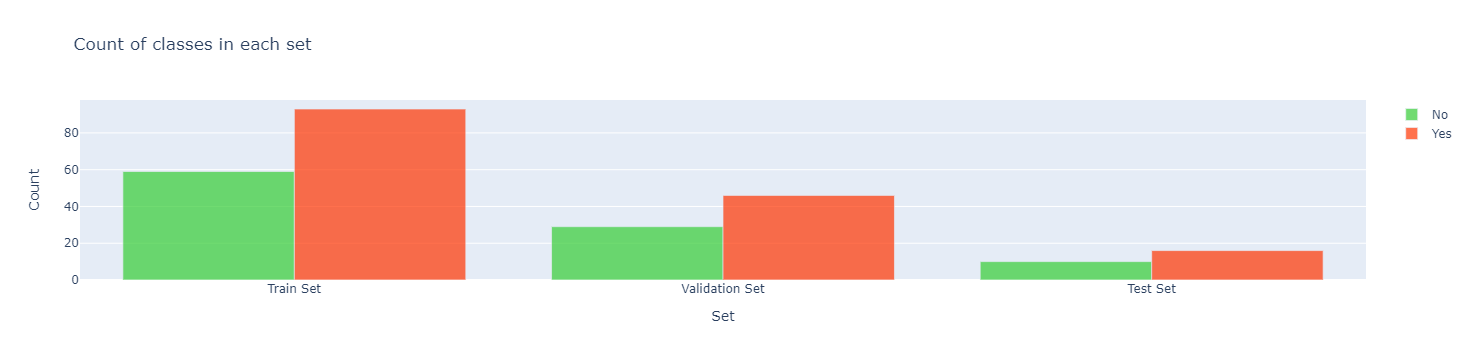

In [6]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [7]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

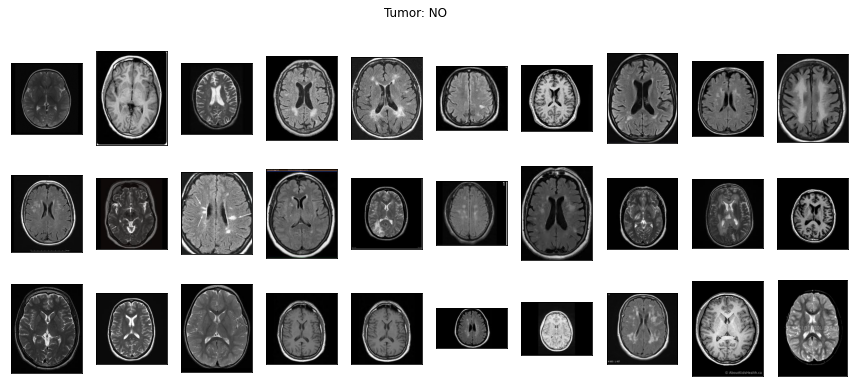

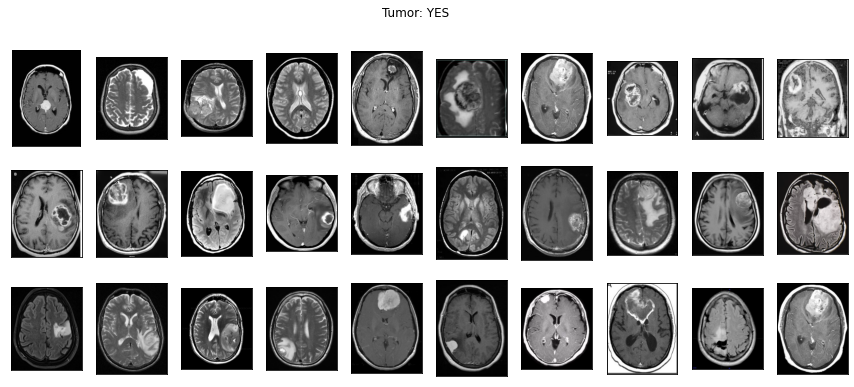

In [8]:
plot_samples(X_train, y_train, labels, 30)

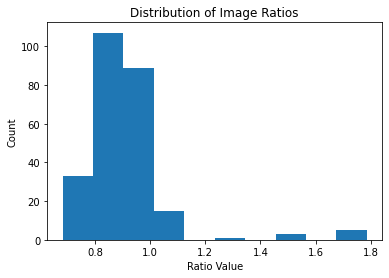

In [9]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [10]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [11]:
img = cv2.imread('dataset/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

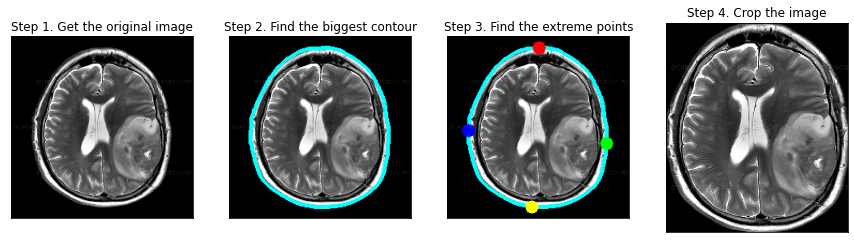

In [12]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [13]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

C:\Users\Acer\AppData\Local\Temp/ipykernel_9832/2254567846.py:31: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



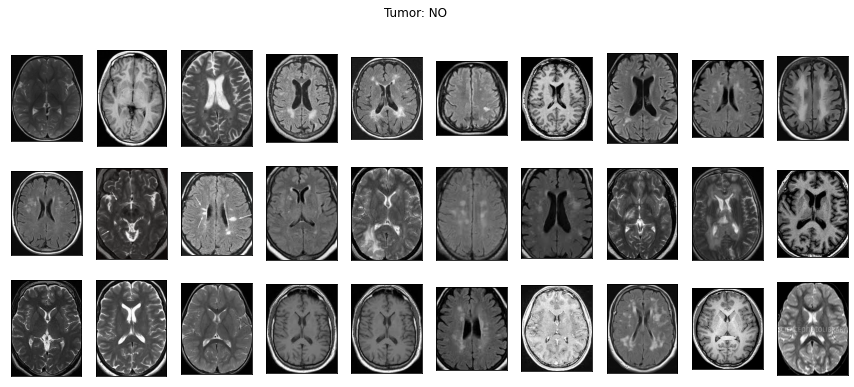

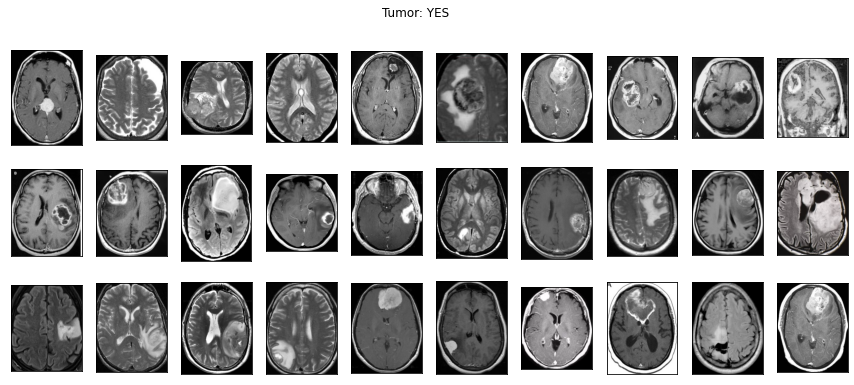

In [14]:
plot_samples(X_train_crop, y_train, labels, 30)

In [15]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [23]:
# saving new images to the folder
save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [24]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [25]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

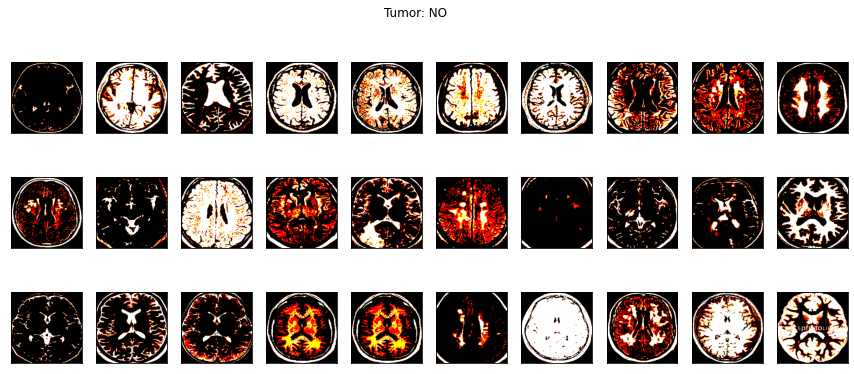

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

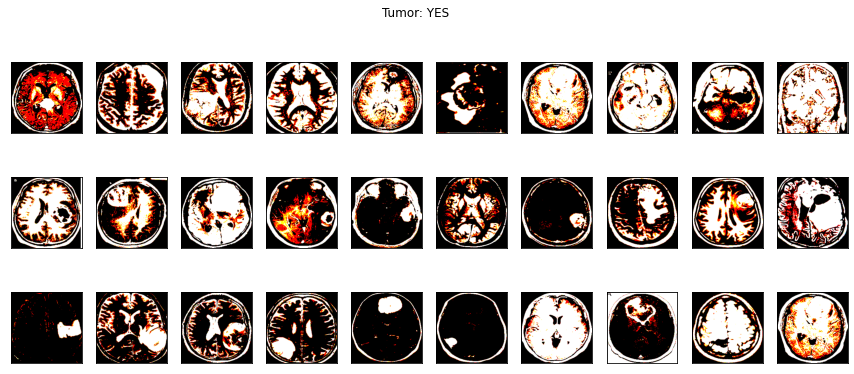

In [26]:
plot_samples(X_train_prep, y_train, labels, 30)

In [27]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [28]:
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

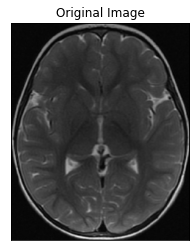

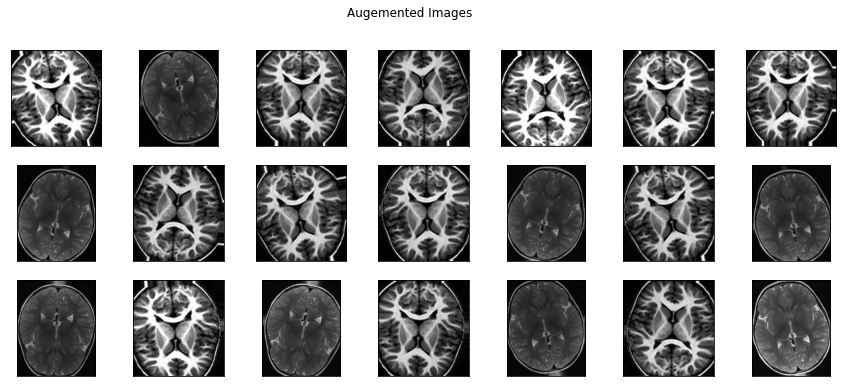

In [29]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [22]:
!rm -rf preview/

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [50]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=(224,224),
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)
print(train_generator.class_indices)

Found 152 images belonging to 2 classes.
Found 75 images belonging to 2 classes.
{'NO': 0, 'YES': 1}


In [162]:
import keras
from keras.layers import Input, Lambda, Dense, Flatten, Concatenate, InputLayer, Add
from keras.models import Model, load_model
from keras.applications.resnet import ResNet50, preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import cv2

In [219]:
inputImage = Input(shape=(224,224,3))
# add preprocessing layer to the front of resnet
vgg = VGG16(input_shape=(224,224,3),input_tensor=inputImage,weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False
    
l1 = Flatten()(vgg.output)
l2 = Dense(4096, activation='relu')(l1)
l3 = Dense(512, activation='relu')(l2)
prediction = Dense(1, activation='sigmoid')(l3)

# create a model object
model = Model(inputs=inputImage , outputs=prediction)

# tell the model what cost and optimization method to use
model.compile(loss=keras.losses.binary_crossentropy,optimizer='adam',metrics=['accuracy'])

In [220]:
class CustomEarlyStopping(keras.callbacks.Callback):
    val_accuracy = {}
    accuracy = {}
    best_weights = None
    
    def __init__(self, patience=None):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
    
    def on_epoch_end(self, epoch, logs=None):
        epoch += 1
        self.accuracy[epoch] = logs['accuracy']
        self.val_accuracy[epoch] = logs['val_accuracy']
    
        if self.patience and epoch > self.patience:
            # best weight if the current loss is less than epoch-patience loss. Simiarly for acc but when larger
            if self.accuracy[epoch] > self.accuracy[epoch-self.patience] and self.val_accuracy[epoch] > self.val_accuracy[epoch-self.patience]:
                self.best_weights = self.model.get_weights()
            else:
                # to stop training
                self.model.stop_training = True
                # Load the best weights
                self.model.set_weights(self.best_weights)
        else:
            # best weight are the current weights
            self.best_weights = self.model.get_weights()


# fit the model
hist = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[CustomEarlyStopping(patience=10)],
)

Epoch 1/100
5/5 [==============================] - 53s 11s/step - loss: 174.5347 - accuracy: 0.5263 - val_loss: 16.7238 - val_accuracy: 0.4000
Epoch 2/100
5/5 [==============================] - 53s 11s/step - loss: 19.6324 - accuracy: 0.4408 - val_loss: 4.6072 - val_accuracy: 0.7600
Epoch 3/100
5/5 [==============================] - 53s 11s/step - loss: 11.3914 - accuracy: 0.6382 - val_loss: 9.8222 - val_accuracy: 0.6800
Epoch 4/100
5/5 [==============================] - 55s 12s/step - loss: 7.8564 - accuracy: 0.7039 - val_loss: 11.5263 - val_accuracy: 0.6000
Epoch 5/100
5/5 [==============================] - 59s 12s/step - loss: 4.7545 - accuracy: 0.7961 - val_loss: 1.6823 - val_accuracy: 0.8400
Epoch 6/100
5/5 [==============================] - 57s 12s/step - loss: 2.4481 - accuracy: 0.8289 - val_loss: 6.9409 - val_accuracy: 0.6267
Epoch 7/100
5/5 [==============================] - 57s 12s/step - loss: 1.7758 - accuracy: 0.8750 - val_loss: 1.2433 - val_accuracy: 0.8533
Epoch 8/100
5/

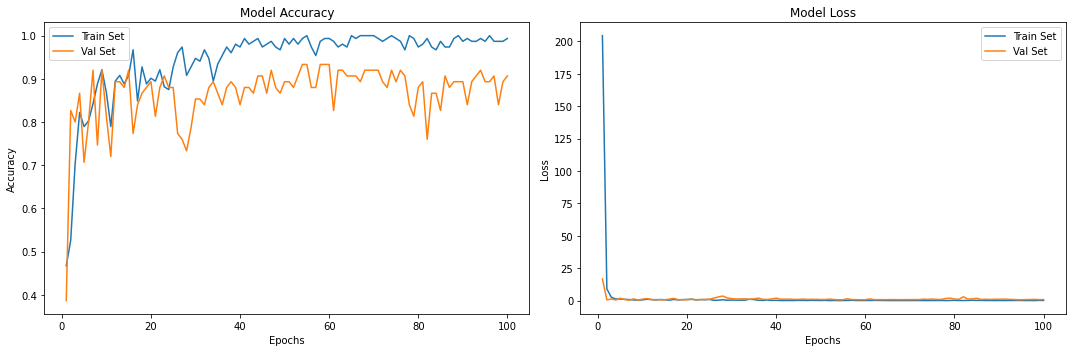

In [166]:
# plot model performance
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs_range = range(1, len(hist.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.84


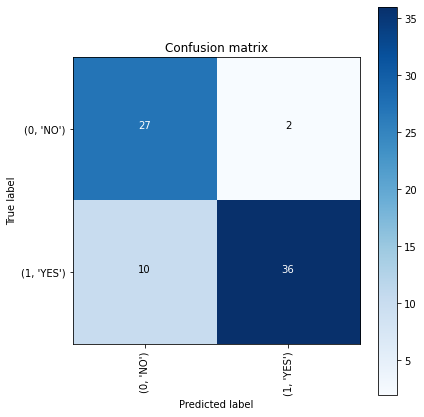

accuracy = 0.84
precision = 0.9310344827586207
sensitivity = 0.7297297297297297
specificity = 0.9473684210526315
f1 score = 0.8181818181818181
fpr =  0.052631578947368474
fnr =  0.2702702702702703
npv =  0.782608695652174
fdr =  0.06896551724137931


In [221]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Test Accuracy = 0.96


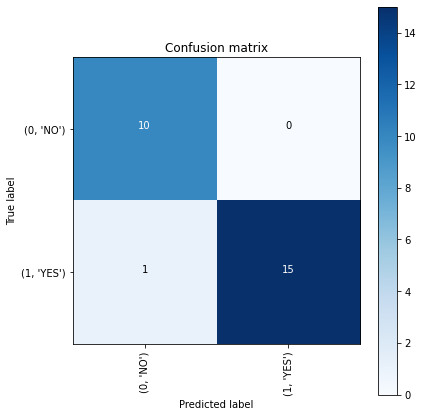

accuracy = 0.9615384615384616
precision = 1.0
sensitivity = 0.9090909090909091
specificity = 1.0
f1 score = 0.9523809523809523
fpr =  0.0
fnr =  0.09090909090909091
npv =  0.9375
fdr =  0.0


In [227]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

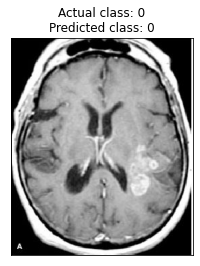

Number of misclassified images:  1


In [228]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
cnt = 0
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()
        cnt += 1
print("Number of misclassified images: ",cnt)

In [224]:
model.save('vgg16.h5')

# RESNET

In [229]:
inputImage = Input(shape=(224,224,3))
# add preprocessing layer to the front of VGG
resnet = ResNet50(input_shape=(224,224,3),input_tensor=inputImage,weights='imagenet', include_top=False)

# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False
    
l1 = Flatten()(resnet.output)
l2 = Dense(4096, activation='relu')(l1)
l3 = Dense(512, activation='relu')(l2)
prediction = Dense(1, activation='sigmoid')(l3)

# create a model object
model = Model(inputs=inputImage , outputs=prediction)

# tell the model what cost and optimization method to use
model.compile(loss=keras.losses.binary_crossentropy,optimizer='adam',metrics=['accuracy'])

In [230]:
class CustomEarlyStopping(keras.callbacks.Callback):
    val_accuracy = {}
    accuracy = {}
    best_weights = None
    
    def __init__(self, patience=None):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
    
    def on_epoch_end(self, epoch, logs=None):
        epoch += 1
        self.accuracy[epoch] = logs['accuracy']
        self.val_accuracy[epoch] = logs['val_accuracy']
    
        if self.patience and epoch > self.patience:
            # best weight if the current loss is less than epoch-patience loss. Simiarly for acc but when larger
            if self.accuracy[epoch] > self.accuracy[epoch-self.patience] and self.val_accuracy[epoch] > self.val_accuracy[epoch-self.patience]:
                self.best_weights = self.model.get_weights()
            else:
                # to stop training
                self.model.stop_training = True
                # Load the best weights
                self.model.set_weights(self.best_weights)
        else:
            # best weight are the current weights
            self.best_weights = self.model.get_weights()


# fit the model
hist = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[CustomEarlyStopping(patience=15)],
)

Epoch 1/100
5/5 [==============================] - 34s 6s/step - loss: 137.3952 - accuracy: 0.4671 - val_loss: 16.4506 - val_accuracy: 0.3867
Epoch 2/100
5/5 [==============================] - 32s 7s/step - loss: 22.7185 - accuracy: 0.6118 - val_loss: 8.6766 - val_accuracy: 0.6133
Epoch 3/100
5/5 [==============================] - 30s 6s/step - loss: 12.5242 - accuracy: 0.4671 - val_loss: 10.2003 - val_accuracy: 0.6133
Epoch 4/100
5/5 [==============================] - 29s 6s/step - loss: 7.3674 - accuracy: 0.6776 - val_loss: 3.9520 - val_accuracy: 0.5867
Epoch 5/100
5/5 [==============================] - 30s 6s/step - loss: 4.0173 - accuracy: 0.7039 - val_loss: 5.4081 - val_accuracy: 0.6533
Epoch 6/100
5/5 [==============================] - 29s 6s/step - loss: 1.8166 - accuracy: 0.8224 - val_loss: 4.4366 - val_accuracy: 0.5600
Epoch 7/100
5/5 [==============================] - 32s 7s/step - loss: 1.8800 - accuracy: 0.7961 - val_loss: 1.6357 - val_accuracy: 0.8133
Epoch 8/100
5/5 [====

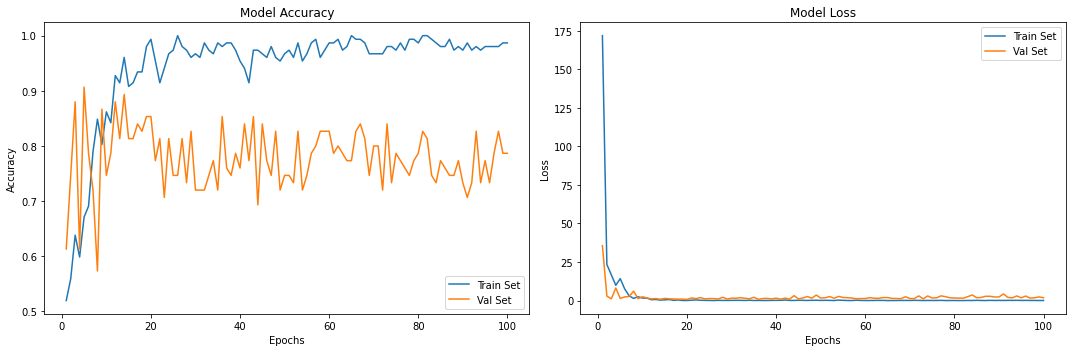

In [82]:
# plot model performance
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs_range = range(1, len(hist.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.83


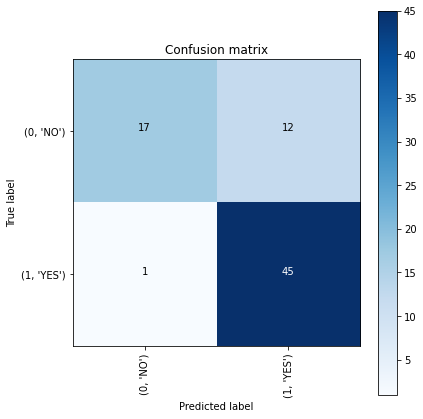

accuracy = 0.8266666666666667
precision = 0.5862068965517241
sensitivity = 0.9444444444444444
specificity = 0.7894736842105263
f1 score = 0.7234042553191489
fpr =  0.21052631578947367
fnr =  0.05555555555555555
npv =  0.9782608695652174
fdr =  0.41379310344827586


In [231]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Test Accuracy = 0.96


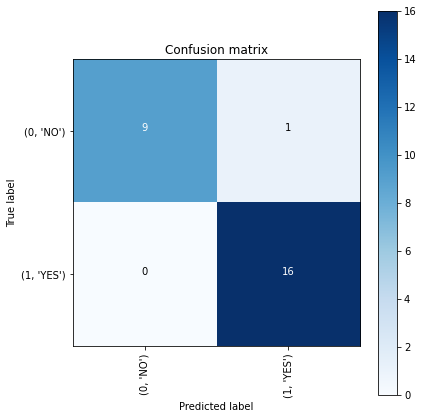

accuracy = 0.9615384615384616
precision = 0.9
sensitivity = 1.0
specificity = 0.9411764705882353
f1 score = 0.9473684210526316
fpr =  0.05882352941176472
fnr =  0.0
npv =  1.0
fdr =  0.1


In [232]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

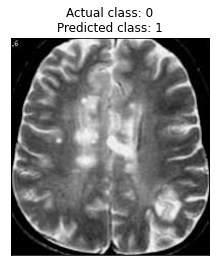

Number of misclassified images:  1


In [236]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
cnt = 0
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()
        cnt += 1
print("Number of misclassified images: ",cnt)

In [234]:
model.save('resnet50.h5')

# Xception

In [237]:
inputImage = Input(shape=(224,224,3))
# add preprocessing layer to the front of VGG
xception = Xception(input_shape=(224,224,3),input_tensor=inputImage,weights='imagenet', include_top=False)

# don't train existing weights
for layer in xception.layers:
    layer.trainable = False
    
l1 = Flatten()(xception.output)
l2 = Dense(4096, activation='relu')(l1)
l3 = Dense(512, activation='relu')(l2)
prediction = Dense(1, activation='sigmoid')(l3)

# create a model object
model = Model(inputs=inputImage , outputs=prediction)

# tell the model what cost and optimization method to use
model.compile(loss=keras.losses.binary_crossentropy,optimizer='adam',metrics=['accuracy'])

In [238]:
class CustomEarlyStopping(keras.callbacks.Callback):
    val_accuracy = {}
    accuracy = {}
    best_weights = None
    
    def __init__(self, patience=None):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
    
    def on_epoch_end(self, epoch, logs=None):
        epoch += 1
        self.accuracy[epoch] = logs['accuracy']
        self.val_accuracy[epoch] = logs['val_accuracy']
    
        if self.patience and epoch > self.patience:
            # best weight if the current loss is less than epoch-patience loss. Simiarly for acc but when larger
            if self.accuracy[epoch] > self.accuracy[epoch-self.patience] and self.val_accuracy[epoch] > self.val_accuracy[epoch-self.patience]:
                self.best_weights = self.model.get_weights()
            else:
                # to stop training
                self.model.stop_training = True
                # Load the best weights
                self.model.set_weights(self.best_weights)
        else:
            # best weight are the current weights
            self.best_weights = self.model.get_weights()


# fit the model
hist = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[CustomEarlyStopping(patience=15)],
)

Epoch 1/100
5/5 [==============================] - 30s 5s/step - loss: 252.5691 - accuracy: 0.5329 - val_loss: 147.9847 - val_accuracy: 0.6133
Epoch 2/100
5/5 [==============================] - 27s 6s/step - loss: 68.8713 - accuracy: 0.5724 - val_loss: 27.4911 - val_accuracy: 0.4133
Epoch 3/100
5/5 [==============================] - 26s 5s/step - loss: 22.6015 - accuracy: 0.5395 - val_loss: 4.2650 - val_accuracy: 0.6133
Epoch 4/100
5/5 [==============================] - 25s 6s/step - loss: 12.3369 - accuracy: 0.5461 - val_loss: 10.9474 - val_accuracy: 0.6667
Epoch 5/100
5/5 [==============================] - 27s 6s/step - loss: 8.1572 - accuracy: 0.6053 - val_loss: 9.2438 - val_accuracy: 0.6667
Epoch 6/100
5/5 [==============================] - 26s 5s/step - loss: 6.3901 - accuracy: 0.6645 - val_loss: 6.2255 - val_accuracy: 0.4533
Epoch 7/100
5/5 [==============================] - 26s 5s/step - loss: 7.4058 - accuracy: 0.6053 - val_loss: 5.1029 - val_accuracy: 0.5600
Epoch 8/100
5/5 [=

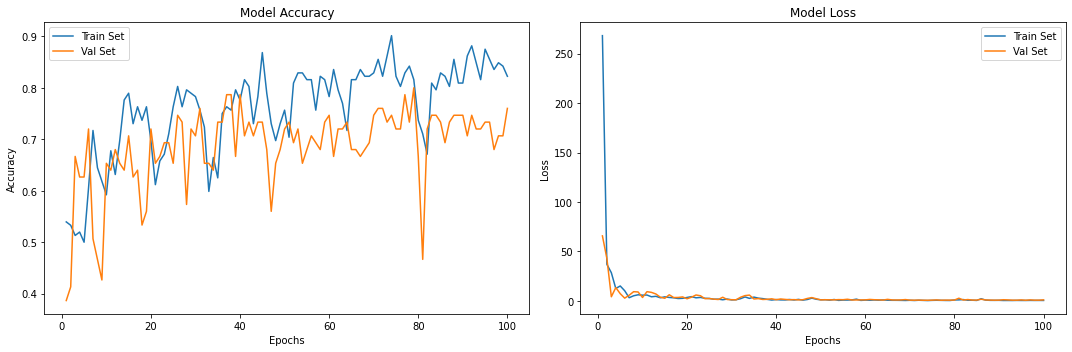

In [95]:
# plot model performance
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs_range = range(1, len(hist.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.69


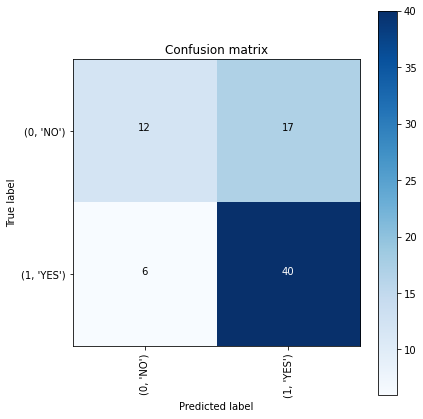

accuracy = 0.6933333333333334
precision = 0.41379310344827586
sensitivity = 0.6666666666666666
specificity = 0.7017543859649122
f1 score = 0.5106382978723404
fpr =  0.29824561403508776
fnr =  0.3333333333333333
npv =  0.8695652173913043
fdr =  0.5862068965517241


In [243]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Test Accuracy = 0.77


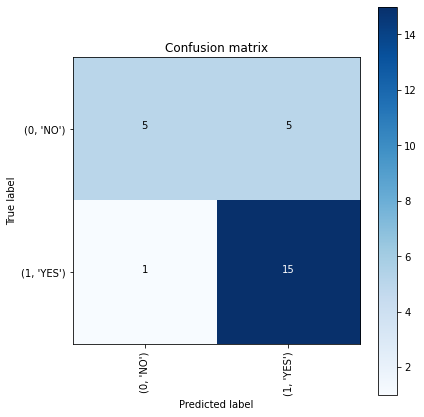

accuracy = 0.7692307692307693
precision = 0.5
sensitivity = 0.8333333333333334
specificity = 0.75
f1 score = 0.625
fpr =  0.25
fnr =  0.16666666666666666
npv =  0.9375
fdr =  0.5


In [244]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

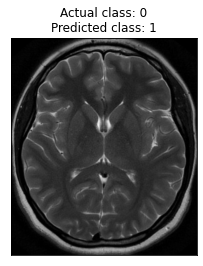

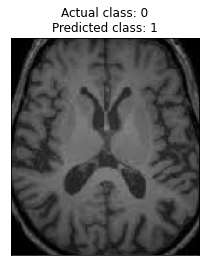

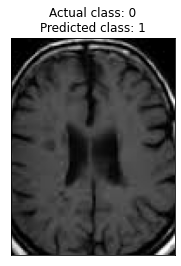

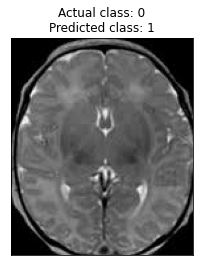

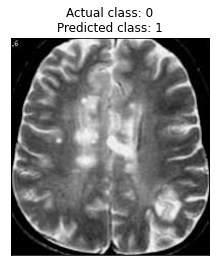

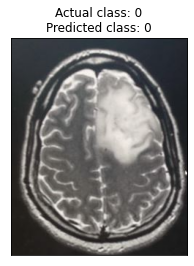

Number of misclassified images:  6


In [245]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
cnt = 0
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()
        cnt += 1
print("Number of misclassified images: ",cnt)

In [246]:
model.save('xception.h5')

# EFFICIENT NET

In [259]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L, preprocess_input
inputImage = Input(shape=(224,224,3))
# add preprocessing layer to the front of VGG
efficient = EfficientNetV2L(input_shape=(224,224,3),input_tensor=inputImage,weights='imagenet', include_top=False)

# don't train existing weights
for layer in efficient.layers:
    layer.trainable = False
    
l1 = Flatten()(efficient.output)
l2 = Dense(4096, activation='relu')(l1)
l3 = Dense(512, activation='relu')(l2)
prediction = Dense(1, activation='sigmoid')(l3)

# create a model object
model = Model(inputs=inputImage , outputs=prediction)

# tell the model what cost and optimization method to use
model.compile(loss=keras.losses.binary_crossentropy,optimizer='adam',metrics=['accuracy'])

In [260]:
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=15,
    restore_best_weights=True
)
            

# fit the model
hist = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[es]
)

Epoch 1/100
5/5 [==============================] - 84s 15s/step - loss: 15.3736 - accuracy: 0.5789 - val_loss: 4.7334 - val_accuracy: 0.6133
Epoch 2/100
5/5 [==============================] - 70s 14s/step - loss: 5.1858 - accuracy: 0.6579 - val_loss: 0.4858 - val_accuracy: 0.8533
Epoch 3/100
5/5 [==============================] - 65s 14s/step - loss: 1.4212 - accuracy: 0.7500 - val_loss: 2.1178 - val_accuracy: 0.6667
Epoch 4/100
5/5 [==============================] - 65s 14s/step - loss: 1.4020 - accuracy: 0.7697 - val_loss: 0.5334 - val_accuracy: 0.8000
Epoch 5/100
5/5 [==============================] - 65s 14s/step - loss: 1.7854 - accuracy: 0.6908 - val_loss: 0.8248 - val_accuracy: 0.8267
Epoch 6/100
5/5 [==============================] - 65s 14s/step - loss: 1.3426 - accuracy: 0.7566 - val_loss: 1.6594 - val_accuracy: 0.7467
Epoch 7/100
5/5 [==============================] - 66s 14s/step - loss: 1.2029 - accuracy: 0.7895 - val_loss: 1.9880 - val_accuracy: 0.6800
Epoch 8/100
5/5 [==

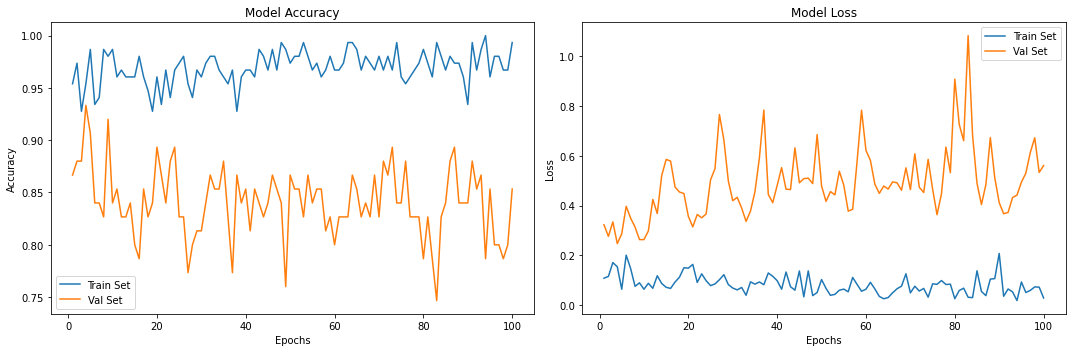

In [107]:
# plot model performance
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs_range = range(1, len(hist.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.92


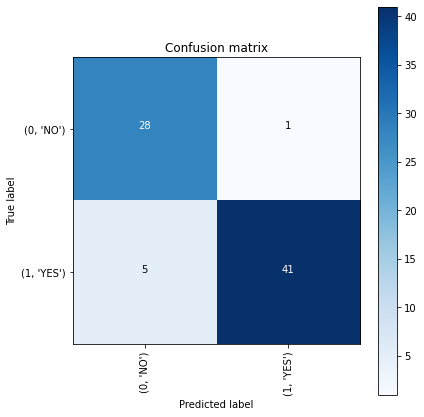

accuracy = 0.92
precision = 0.9655172413793104
sensitivity = 0.8484848484848485
specificity = 0.9761904761904762
f1 score = 0.9032258064516129
fpr =  0.023809523809523836
fnr =  0.15151515151515152
npv =  0.8913043478260869
fdr =  0.034482758620689655


In [261]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Test Accuracy = 0.92


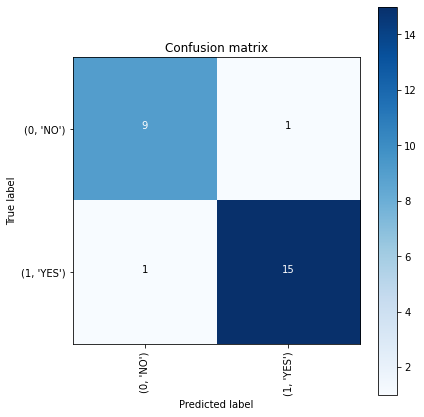

accuracy = 0.9230769230769231
precision = 0.9
sensitivity = 0.9
specificity = 0.9375
f1 score = 0.9
fpr =  0.0625
fnr =  0.1
npv =  0.9375
fdr =  0.1


In [262]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

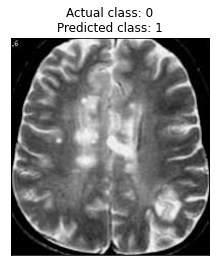

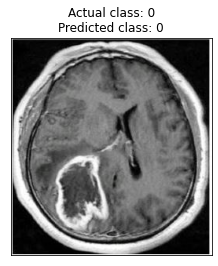

Number of misclassified images:  2


In [263]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
cnt = 0
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()
        cnt += 1
print("Number of misclassified images: ",cnt)

In [264]:
model.save('efficient.h5')

# SCRATCH

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import * 
from keras.preprocessing import image

In [3]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.summary()

model.compile(loss=keras.losses.binary_crossentropy,optimizer='adam',metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 110, 110, 64)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 108, 108, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                  

In [283]:
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=15,
    restore_best_weights=True
)
            

# fit the model
hist = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[es]
)

Epoch 1/100
5/5 [==============================] - 23s 4s/step - loss: 0.6871 - accuracy: 0.5658 - val_loss: 0.6885 - val_accuracy: 0.6133
Epoch 2/100
5/5 [==============================] - 21s 4s/step - loss: 0.6808 - accuracy: 0.6053 - val_loss: 0.6866 - val_accuracy: 0.6133
Epoch 3/100
5/5 [==============================] - 21s 4s/step - loss: 0.6832 - accuracy: 0.6184 - val_loss: 0.6872 - val_accuracy: 0.6133
Epoch 4/100
5/5 [==============================] - 22s 4s/step - loss: 0.6869 - accuracy: 0.5921 - val_loss: 0.6868 - val_accuracy: 0.6133
Epoch 5/100
5/5 [==============================] - 22s 4s/step - loss: 0.6850 - accuracy: 0.6118 - val_loss: 0.6861 - val_accuracy: 0.6133
Epoch 6/100
5/5 [==============================] - 22s 4s/step - loss: 0.6842 - accuracy: 0.5855 - val_loss: 0.6854 - val_accuracy: 0.6133
Epoch 7/100
5/5 [==============================] - 21s 4s/step - loss: 0.6888 - accuracy: 0.5855 - val_loss: 0.6847 - val_accuracy: 0.6133
Epoch 8/100
5/5 [==========

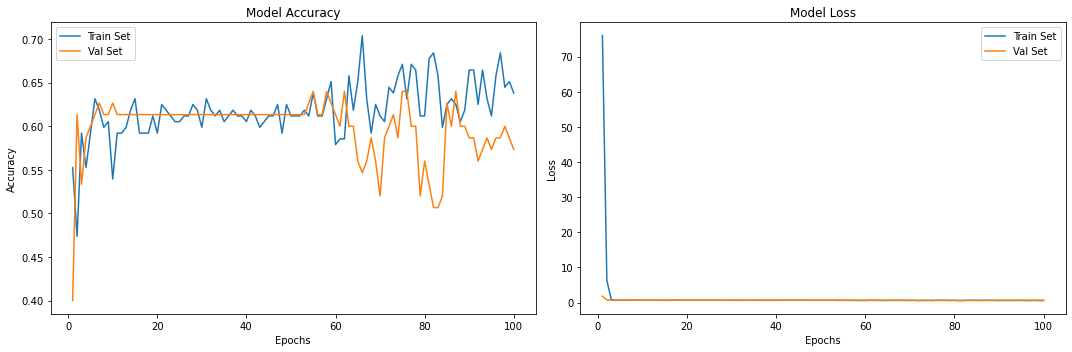

In [127]:
# plot model performance
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs_range = range(1, len(hist.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.61


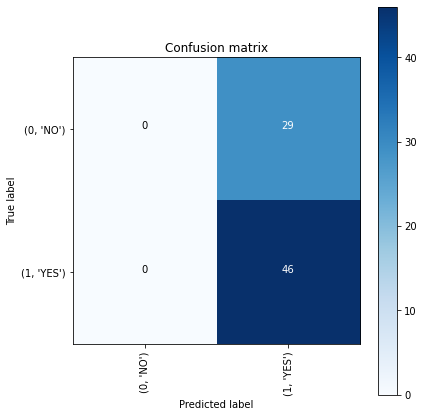

accuracy = 0.6133333333333333
precision = 0.0
sensitivity = nan
specificity = 0.6133333333333333
f1 score = nan
fpr =  0.3866666666666667
fnr =  nan
npv =  1.0
fdr =  1.0


C:\Users\Acer\AppData\Local\Temp/ipykernel_9832/1442132786.py:61: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\Acer\AppData\Local\Temp/ipykernel_9832/1442132786.py:63: RuntimeWarning:

invalid value encountered in longlong_scalars



In [286]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Test Accuracy = 0.62


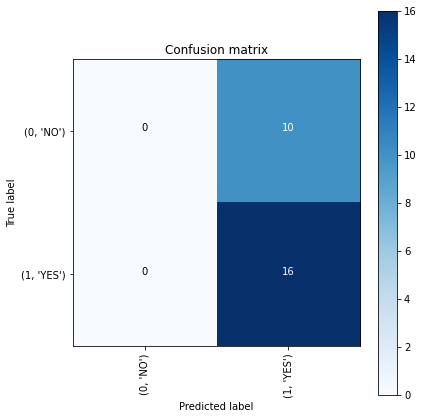

accuracy = 0.6153846153846154
precision = 0.0
sensitivity = nan
specificity = 0.6153846153846154
f1 score = nan
fpr =  0.3846153846153846
fnr =  nan
npv =  1.0
fdr =  1.0


C:\Users\Acer\AppData\Local\Temp/ipykernel_9832/1442132786.py:61: RuntimeWarning:

invalid value encountered in longlong_scalars

C:\Users\Acer\AppData\Local\Temp/ipykernel_9832/1442132786.py:63: RuntimeWarning:

invalid value encountered in longlong_scalars



In [287]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

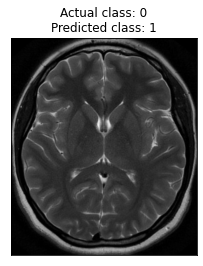

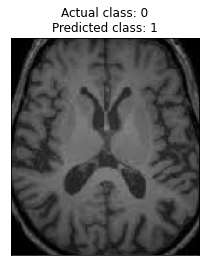

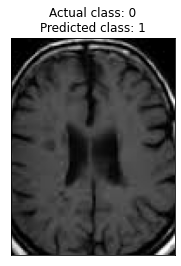

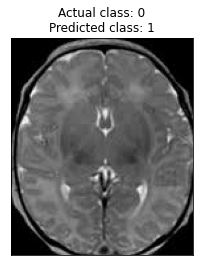

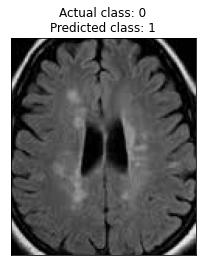

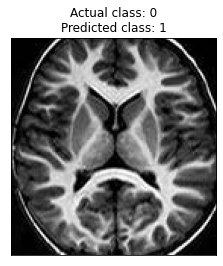

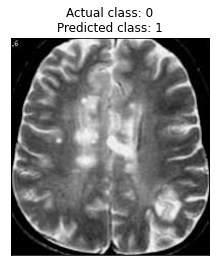

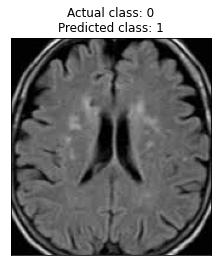

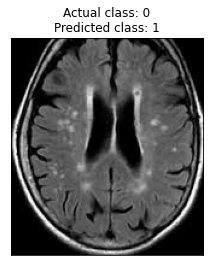

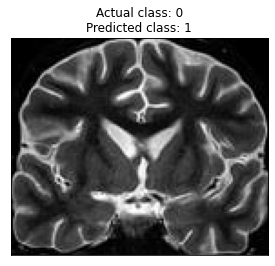

Number of misclassified images:  10


In [289]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
cnt = 0
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()
        cnt += 1
print("Number of misclassified images: ",cnt)

In [131]:
model.save('scratch.h5')

# ENSEMBLE (VGG AND RESNET)

In [265]:
import tensorflow as tf
import keras
from keras.layers import Input, Lambda, Dense, Flatten, Concatenate, InputLayer, Add
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet import ResNet50, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [266]:
inputImage = Input(shape=(224,224,3))
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=(224,224,3),input_tensor=inputImage,weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

resnet = ResNet50(input_shape=(224,224,3),input_tensor=inputImage,weights='imagenet', include_top=False)

# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False


# our layers - you can add more if you want
x1 = Flatten()(vgg.output)
x2 = Flatten()(resnet.output)

concatted = Concatenate()([x1,x2])

x3 = Dense(512, activation='relu')(concatted)
prediction = Dense(1, activation='sigmoid')(x3)

# create a model object
model = Model(inputs=inputImage , outputs=prediction)

# tell the model what cost and optimization method to use
model.compile(loss=keras.losses.binary_crossentropy,optimizer='adam',metrics=['accuracy'])

In [267]:
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=15,
    restore_best_weights=True
)
            

# fit the model
hist = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[es]
)

Epoch 1/100
5/5 [==============================] - 84s 17s/step - loss: 75.6961 - accuracy: 0.5000 - val_loss: 24.0253 - val_accuracy: 0.6267
Epoch 2/100
5/5 [==============================] - 80s 17s/step - loss: 14.7839 - accuracy: 0.7500 - val_loss: 17.1163 - val_accuracy: 0.5867
Epoch 3/100
5/5 [==============================] - 80s 18s/step - loss: 6.9770 - accuracy: 0.7632 - val_loss: 3.3829 - val_accuracy: 0.8400
Epoch 4/100
5/5 [==============================] - 80s 18s/step - loss: 7.9604 - accuracy: 0.7895 - val_loss: 4.3109 - val_accuracy: 0.8800
Epoch 5/100
5/5 [==============================] - 80s 17s/step - loss: 4.5359 - accuracy: 0.8816 - val_loss: 2.9073 - val_accuracy: 0.9067
Epoch 6/100
5/5 [==============================] - 83s 18s/step - loss: 3.0251 - accuracy: 0.9276 - val_loss: 4.1604 - val_accuracy: 0.8667
Epoch 7/100
5/5 [==============================] - 84s 18s/step - loss: 1.1326 - accuracy: 0.9605 - val_loss: 4.1816 - val_accuracy: 0.8667
Epoch 8/100
5/5 

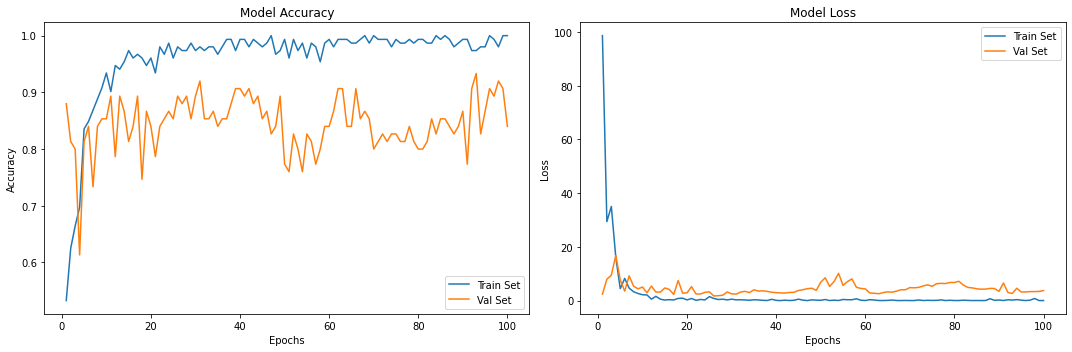

In [136]:
# plot model performance
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs_range = range(1, len(hist.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.91


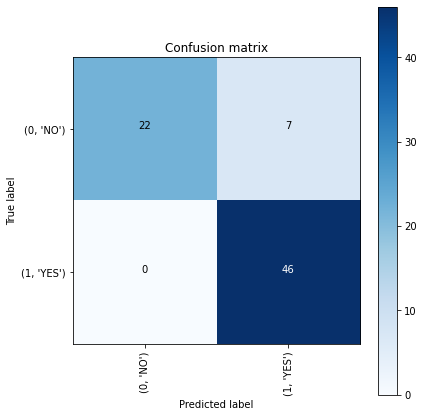

accuracy = 0.9066666666666666
precision = 0.7586206896551724
sensitivity = 1.0
specificity = 0.8679245283018868
f1 score = 0.8627450980392156
fpr =  0.13207547169811318
fnr =  0.0
npv =  1.0
fdr =  0.2413793103448276


In [268]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Test Accuracy = 0.96


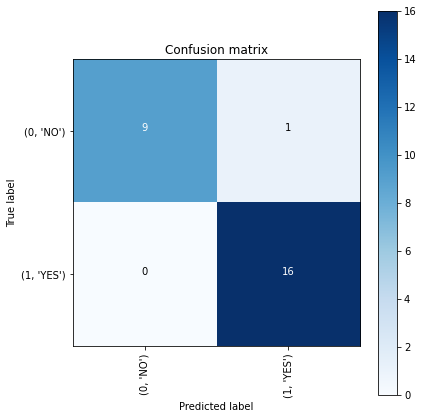

accuracy = 0.9615384615384616
precision = 0.9
sensitivity = 1.0
specificity = 0.9411764705882353
f1 score = 0.9473684210526316
fpr =  0.05882352941176472
fnr =  0.0
npv =  1.0
fdr =  0.1


In [269]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

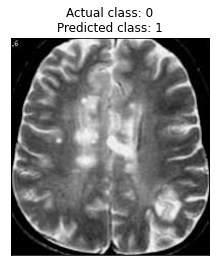

Number of misclassified images:  1


In [272]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
cnt = 0
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()
        cnt += 1
print("Number of misclassified images: ",cnt)

In [271]:
model.save('vgg_resnet.h5')

# Ensemble vgg, efficient

In [273]:
inputImage = Input(shape=(224,224,3))
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=(224,224,3),input_tensor=inputImage,weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

efficient = EfficientNetV2L(input_shape=(224,224,3),input_tensor=inputImage,weights='imagenet', include_top=False)

# don't train existing weights
for layer in efficient.layers:
    layer.trainable = False


# our layers - you can add more if you want
x1 = Flatten()(vgg.output)
x2 = Flatten()(efficient.output)

concatted = Concatenate()([x1,x2])

x3 = Dense(512, activation='relu')(concatted)
#x4 = Dense(512, activation='relu')(x3)
prediction = Dense(1, activation='sigmoid')(x3)

# create a model object
model = Model(inputs=inputImage , outputs=prediction)


# tell the model what cost and optimization method to use
model.compile(loss=keras.losses.binary_crossentropy,optimizer='adam',metrics=['accuracy'])

In [274]:
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=15,
    restore_best_weights=True
)
            

# fit the model
hist = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[es]
)

Epoch 1/100
5/5 [==============================] - 140s 24s/step - loss: 37.2756 - accuracy: 0.5329 - val_loss: 10.8215 - val_accuracy: 0.7067
Epoch 2/100
5/5 [==============================] - 110s 23s/step - loss: 8.8543 - accuracy: 0.7961 - val_loss: 19.5433 - val_accuracy: 0.5467
Epoch 3/100
5/5 [==============================] - 110s 24s/step - loss: 10.3465 - accuracy: 0.7039 - val_loss: 12.7051 - val_accuracy: 0.6800
Epoch 4/100
5/5 [==============================] - 114s 24s/step - loss: 8.7887 - accuracy: 0.7566 - val_loss: 8.0650 - val_accuracy: 0.6800
Epoch 5/100
5/5 [==============================] - 116s 25s/step - loss: 5.7286 - accuracy: 0.7829 - val_loss: 0.6336 - val_accuracy: 0.8800
Epoch 6/100
5/5 [==============================] - 108s 23s/step - loss: 4.2756 - accuracy: 0.8421 - val_loss: 1.0405 - val_accuracy: 0.9067
Epoch 7/100
5/5 [==============================] - 116s 25s/step - loss: 1.4147 - accuracy: 0.8947 - val_loss: 1.9728 - val_accuracy: 0.9333
Epoch 8/

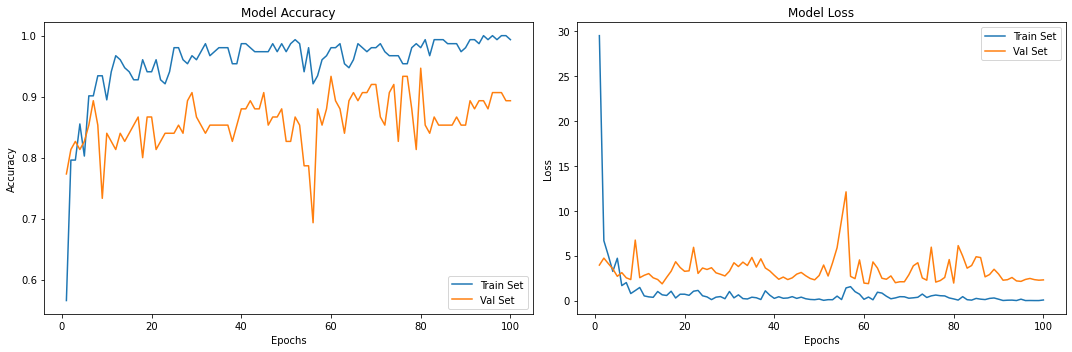

In [145]:
# plot model performance
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs_range = range(1, len(hist.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.95


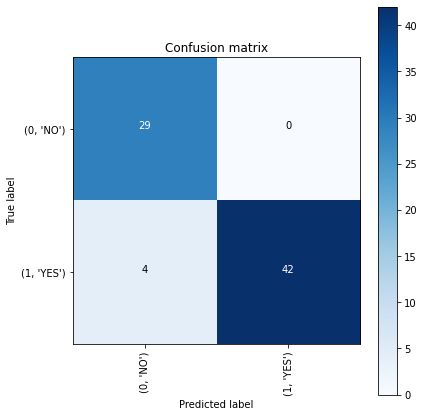

accuracy = 0.9466666666666667
precision = 1.0
sensitivity = 0.8787878787878788
specificity = 1.0
f1 score = 0.9354838709677419
fpr =  0.0
fnr =  0.12121212121212122
npv =  0.9130434782608695
fdr =  0.0


In [275]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Test Accuracy = 0.88


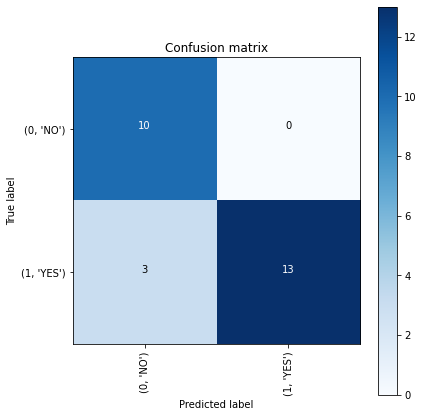

accuracy = 0.8846153846153846
precision = 1.0
sensitivity = 0.7692307692307693
specificity = 1.0
f1 score = 0.8695652173913044
fpr =  0.0
fnr =  0.23076923076923078
npv =  0.8125
fdr =  0.0


In [276]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

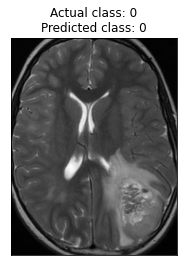

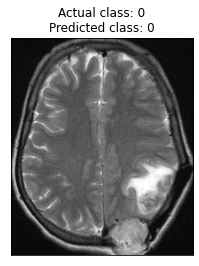

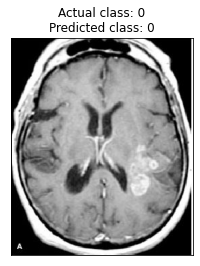

Number of misclassified images:  3


In [279]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
cnt = 0
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()
        cnt += 1
print("Number of misclassified images: ",cnt)

In [278]:
model.save('vgg_efficient.h5')